# NLP Exploration of Stackexchange Data Dump - Data Science subset
## Bruce Okallau

Stackexchange is a community driven network of websites where users of various technologies can post questions and answers. Questions and answers are rated by other users and curated as the answers can be useful to more than one user. Stackexchange provides anonymized data on the users, posts, comments, and votes in various site subtopics. The data includes the text in the title and body of the posts as well as numeric metrics (score, view count, answer count, etc.).

Data can be found here: https://archive.org/details/stackexchange

Thanks to 'adich23' for the github notebook to convert xml to csv in pyspark

-6.0
113.0


(array([  1.47910000e+04,   1.24100000e+03,   9.30000000e+01,
          3.10000000e+01,   6.00000000e+00,   8.00000000e+00,
          4.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          2.00000000e+00]),
 array([  -6. ,    5.9,   17.8,   29.7,   41.6,   53.5,   65.4,   77.3,
          89.2,  101.1,  113. ]),
 <a list of 10 Patch objects>)

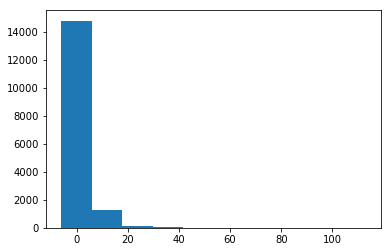

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

posts1 = pd.read_csv('posts_1.csv')

posts2 = pd.read_csv('posts_2.csv')
posts3 = pd.read_csv('posts_3.csv')
posts4 = pd.read_csv('posts_4.csv')

posts = pd.concat([posts1,posts2,posts3,posts4], axis=0)

# 'Score' is the number of upvotes - downvotes and is an indicator of the quality of the post

# distribution of scores
print(min(posts['Score']))
# -6

print(max(posts['Score']))
# 113

plt.hist(posts['Score'][~pd.isnull(posts['Score'])])

Most posts have a score of 0. Perhaps there is room for improvement. The distribution for ViewCount, AnswerCount, and FavoriteCount are very simliar.

Is there a relationship between the words in the title and score?

In [2]:
# filter data set 
posts_titles = posts[~pd.isnull(posts['Title'])]

# how many missing values?
print(sum(posts_titles['Score'].isnull().values.ravel()))
# 0

# Cleaning the texts
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
posts_titles = posts_titles.reset_index(drop=True)

corpus = []

for i in range(len(posts_titles)):
    title = re.sub('[^a-zA-Z_0-9]', ' ', posts_titles['Title'][i])
    title = title.lower()
    title = title.split()
    ps = PorterStemmer()
    title = [ps.stem(word) for word in title if not word in set(stopwords.words('english'))]
    title = ' '.join(title)
    corpus.append(title)

# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 7000)
X = cv.fit_transform(corpus).toarray()
Y = posts_titles['Score']

print(X.shape)

0
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bruceokallau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
(7113, 4037)


4037 different words used in titles of 7113 posts. Will reduce dimentionality with PCA.

In [4]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

# Applying PCA
from sklearn.decomposition import PCA
pca50 = PCA(n_components = 50)
X_train_50 = pca50.fit_transform(X_train)
X_test_50 = pca50.transform(X_test)

import lightgbm as lgb
X_50_resampled, X_50_valid, Y_resampled, Y_valid = train_test_split(X_train_50, Y_train, test_size = 0.2, random_state = 42)

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_50_resampled, Y_resampled)
lgb_eval = lgb.Dataset(X_50_valid, Y_valid, reference=lgb_train)

params = {
        'objective': 'regression',
        'metric': 'MAE',
        'learning_rate': 0.01,
        'verbose': 0}

gbm = lgb.train(params, lgb_train, num_boost_round=2000, valid_sets=lgb_eval, early_stopping_rounds=50)

[1]	valid_0's l1: 1.96609
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l1: 1.96563
[3]	valid_0's l1: 1.96534
[4]	valid_0's l1: 1.96479
[5]	valid_0's l1: 1.96414
[6]	valid_0's l1: 1.96371
[7]	valid_0's l1: 1.96316
[8]	valid_0's l1: 1.96245
[9]	valid_0's l1: 1.96258
[10]	valid_0's l1: 1.96194
[11]	valid_0's l1: 1.96219
[12]	valid_0's l1: 1.96132
[13]	valid_0's l1: 1.96135
[14]	valid_0's l1: 1.96141
[15]	valid_0's l1: 1.96133
[16]	valid_0's l1: 1.96139
[17]	valid_0's l1: 1.96066
[18]	valid_0's l1: 1.9605
[19]	valid_0's l1: 1.96006
[20]	valid_0's l1: 1.9595
[21]	valid_0's l1: 1.95918
[22]	valid_0's l1: 1.95941
[23]	valid_0's l1: 1.95905
[24]	valid_0's l1: 1.95921
[25]	valid_0's l1: 1.95904
[26]	valid_0's l1: 1.95884
[27]	valid_0's l1: 1.959
[28]	valid_0's l1: 1.95871
[29]	valid_0's l1: 1.95851
[30]	valid_0's l1: 1.95869
[31]	valid_0's l1: 1.95856
[32]	valid_0's l1: 1.95862
[33]	valid_0's l1: 1.95897
[34]	valid_0's l1: 1.95856
[35]	valid_0's l1: 1.95843
[36]	v

In [6]:
from sklearn.metrics import mean_absolute_error
Y_gbm = gbm.predict(X_test_50)
print(mean_absolute_error(Y_test, Y_gbm))

2.15847975038


Good agreement from validation set to test set. Predictions off by 2 points on score where the range is -6 to 113.

(array([  1.02800000e+03,   3.67000000e+02,   1.60000000e+01,
          9.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ -8.48647381,   0.5655367 ,   9.6175472 ,  18.66955771,
         27.72156822,  36.77357872,  45.82558923,  54.87759973,
         63.92961024,  72.98162074,  82.03363125]),
 <a list of 10 Patch objects>)

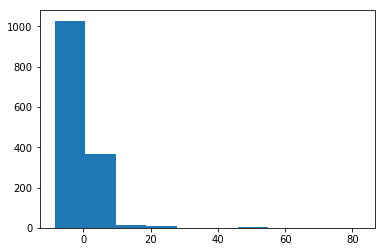

In [15]:
res_gbm = Y_test - Y_gbm
plt.hist(res_gbm)

Residuals are not normally distributed. There are most likely more patterns that can be found and used to make better predictions. PCA might not be the best technique for dimentionality reduction.